```
Created on Sep 11, 2019
将来的なcitation予測を行う
出版後n年後のtop x% tierの論文を予測する

@author: ochi
```

In [1]:
import collections as cl
import codecs
import sys
import matplotlib

import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import os
import shutil
import csv
import random
import numpy as np
import sklearn.linear_model as slm
import sklearn.metrics as smt
import sklearn.metrics.pairwise as smp
import sklearn.neighbors as sn
import scipy.stats as ss
import seaborn as sns


In [2]:
def readSelectedPapersFile(filepath,delimiter=','):
    papers = []
    with open(filepath, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            eid = row[0]
            papers.append(eid)

    return papers

In [3]:
def readLabeledFile(afile, delimiter=','):
    labelDic = {}
    with open(afile, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            aid = row[0]
            label = row[1]
            labelDic[aid] = label

    return labelDic

In [4]:
def readVectorFile(vec_file, delimiter=' '):
    vecDic = {}
    with open(vec_file, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            if i == 0:
                # header line
                continue
            else:
                node = row[0]
                vec = np.array(row[1:-1],dtype=np.float)
                vecDic[node] = vec
            pass
    return vecDic

In [5]:
def makeMTXData(labelDic,vecDic,selected_authors,ref_aids=[]):
    xs = []
    ys = []
    vec_keys = set(vecDic.keys())
   
    selected_aids = []
#    aids = list(set(vecDic.keys())&set(labelDic.keys()))
    if len(ref_aids) == 0:
        aids = list(set(vecDic.keys())&set(labelDic.keys()))
    else:
        aids = ref_aids

    for i, aid in enumerate(aids):
        if aid not in vec_keys:
            continue

        selected_aids.append(aid)

        au_vec = vecDic[aid]
        distances = []
        label = labelDic[aid]
        for t_id in selected_authors:
            t_vec = vecDic[t_id]
#            distance = smp.cosine_distances([au_vec],[t_vec])[0,0]
            distance = smp.cosine_similarity([au_vec],[t_vec])[0,0]
            distances.append(distance)

#        a_x = distances
        # 近い順に並べてみる
        distances = sorted(distances, key=lambda x:-x)
#        distances.append(float(label)) #特徴量に訓練させるラベルをまさかの追加
        a_x = distances
#        a_x = au_vec
        xs.append(a_x)
        y = int(labelDic[aid])
        ys.append(y)

    print("cos sim sorted")
    print(set(ys))
    y = np.array(ys, dtype=np.int).reshape((len(ys),1))
    print(y.shape)
    x = np.array(xs, dtype=np.float)
    print(x.shape)
    return x, y, selected_aids

In [30]:
def drawPRCMulti(yDic,probDic):

    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
        print(name)
        probs = probDic[name]
        y     = yDic[name]
        print(y[0:100])
        print(probs[0:100])
#        precision, recall, thresholds = smt.precision_recall_curve(y,probs)
#        ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        if len(set(probs)) > 2:
            precision, recall, thresholds = smt.precision_recall_curve(y,probs)
            ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])
        else:
            precision = smt.precision_score(y,probs)
            recall    = smt.recall_score(y,probs)
            ax.step(recall, precision, 'x', color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        print(name)
        print("precision")
        print(precision)
        print("recall")
        print(recall)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall Rate')
    ax.set_ylabel('Precision Rate')
    ax.set_title('Future Citation Prediction Precision-Recall Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

    fig.savefig("citation_prediction_precision_recall_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

In [7]:
cv=0
order='1'
itr='3000'
rho='0.05'
#th="0.001000"
th="0.200000"
n_year='3'

train_file   = "../../scopus_xml_scraper/csv01/top%sornot_published2009_after%s.csv"%(th,n_year)
test_file    = "../../scopus_xml_scraper/csv01/top%sornot_published2013_after%s.csv"%(th,n_year)
compare_results_file    = "../../scopus_xml_scraper/csv01/top%sornot_published2009_after%s.csv"%(th,n_year)

selectedpapers_file = "../../scopus_xml_scraper/csv01/select10papers_published2009_after3.csv"

vectorfileDic = {
    "non_2009":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
    "non_2013":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
}

In [8]:
selected_papers = readSelectedPapersFile(selectedpapers_file)
train_labelDic = readLabeledFile(train_file)
test_labelDic  = readLabeledFile(test_file)
compare_labelDic = readLabeledFile(compare_results_file)

In [9]:
print(selected_papers)

['2-s2.0-67649207662', '2-s2.0-70350774564', '2-s2.0-66149086912', '2-s2.0-60449087889', '2-s2.0-72849124207', '2-s2.0-73249138888', '2-s2.0-70349784869', '2-s2.0-67650555653', '2-s2.0-67649388867', '2-s2.0-66149116003']


In [10]:
train_vec_file = vectorfileDic["non_2009"]
train_vecDic = readVectorFile(train_vec_file)
print("complete getting train vectors")


complete getting train vectors


In [11]:
test_vec_file = vectorfileDic["non_2013"]
test_vecDic = readVectorFile(test_vec_file)
print("complete getting test vectors")

complete getting test vectors


In [12]:
train_eids = list(set(train_vecDic.keys())&set(train_labelDic.keys()))
print(len(train_eids))
print(len(list(set(test_vecDic.keys()))))
test_eids  = list(set(test_vecDic.keys()) & set(test_labelDic.keys()))
selected_papers = list(set(train_eids)&set(selected_papers)) # train papersはテストデータとかぶりがない
print(len(test_eids))
print(selected_papers)
print("complete selecting papers")

11845
3179042
18674
['2-s2.0-66149086912', '2-s2.0-67649207662', '2-s2.0-67649388867', '2-s2.0-70350774564', '2-s2.0-67650555653', '2-s2.0-66149116003', '2-s2.0-60449087889', '2-s2.0-72849124207', '2-s2.0-73249138888', '2-s2.0-70349784869']
complete selecting papers


In [19]:
train_x, train_y, train_eids =  makeMTXData(train_labelDic,train_vecDic,selected_papers)
print("complete making train_xy")

cos sim sorted
{0, 1}
(11845, 1)
(11845, 10)
complete making train_xy


In [18]:
test_x,  test_y,  test_eids  =  makeMTXData(test_labelDic,test_vecDic,selected_papers)
print("complete making test_xy")

tys = []
#compare_eids = compare_labelDic.keys()
for eid in test_eids:
    a_val = random.random()
    if a_val <= float(th):
        l = 1
    else:
        l = 0

    tys.append(l)
    
compare_y = np.array(tys, dtype=np.int).reshape((len(tys),1))

cos sim sorted
{0, 1}
(18674, 1)
(18674, 10)
complete making test_xy


In [20]:
def getCompareResults(eids,compare_results_file):
    compare_labelDic = readLabeledFile(compare_results_file)
    test_compare_res = []
    for eid in eids:
        label = int(compare_labelDic[eid])
#        if label == 0:
#            label = -0.1
#        elif label == 1:
#            label = 1.1
        test_compare_res.append(label)

    return test_compare_res

In [21]:
model = slm.LogisticRegression(penalty='l2',tol=1e-6,C=1.0,warm_start=True)
model.fit(train_x, train_y)
print("complete lr model fit")
print("lr model weightsk")
print(model.coef_[0,:])
test_probs = model.predict_proba(test_x)[:,1]
print(test_probs)
print(test_y)
#for i, p in enumerate(test_probs):
#    print("%s,prob:%f,y:%d"%(test_eids[i],p,test_y[i][0]))
    
print("complete lr model predict")


complete lr model fit
lr model weightsk
[ 4.0555901   3.64337456  1.45907562  0.47964321 -0.50187481 -0.95434597
 -1.18716163 -1.40415974  0.50739952  1.37828833]
[ 0.16644939  0.1295688   0.75047486 ...,  0.85760669  0.12927477
  0.12935227]
[[0]
 [0]
 [1]
 ..., 
 [1]
 [0]
 [0]]
complete lr model predict


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
import random

test_probDic = {}
test_yDic = {}

#test_compare_res = getCompareResults(test_eids, compare_results_file)
test_compare_res = compare_y
test_compare_res1 = []
for res in test_compare_res:
    if res == 0:
        n_res = 0.25
    else:
        n_res = 0.75
    n_res += (random.random()-0.5)/2.0
    test_compare_res1.append(n_res)

test_probDic["non_2013"] = test_probs

test_probDic["citation2013"] = [float(ele) for ele in test_compare_res1]
#test_probDic["random"] = [random.random() for i in range(test_y.shape[0])]
test_yDic["non_2013"]    = test_y
#test_yDic["random"]    = test_y
test_yDic["citation2013"]    = test_y

print("Complete: %s LogisticRegression"%("non_2013"))

Complete: non_2013 LogisticRegression


In [23]:
def printPRF(yDic,probDic,pths=[i/100.0 for i in range(100)]):
    for pth in pths:
        for label in probDic.keys():
            plabels = []
            for prob in probDic[label]:
                if prob >= pth:
                    plabels.append(1)
                else:
                    plabels.append(0)

            (precision, recall, fscore, support) = smt.precision_recall_fscore_support(yDic[label], plabels, average="binary")
            print("pth=%.2f,method=%s,%f,%f,%f"%(pth,label,precision,recall,fscore))

    return

In [24]:
printPRF(test_yDic,test_probDic)

pth=0.00,method=non_2013,0.199957,1.000000,0.333274
pth=0.00,method=citation2013,0.199957,1.000000,0.333274
pth=0.01,method=non_2013,0.199957,1.000000,0.333274
pth=0.01,method=citation2013,0.199662,0.981789,0.331840
pth=0.02,method=non_2013,0.199957,1.000000,0.333274
pth=0.02,method=citation2013,0.199037,0.963310,0.329909
pth=0.03,method=non_2013,0.199957,1.000000,0.333274
pth=0.03,method=citation2013,0.198446,0.943760,0.327936
pth=0.04,method=non_2013,0.199957,1.000000,0.333274
pth=0.04,method=citation2013,0.198900,0.929834,0.327702
pth=0.05,method=non_2013,0.199957,1.000000,0.333274
pth=0.05,method=citation2013,0.199487,0.916176,0.327635
pth=0.06,method=non_2013,0.199957,1.000000,0.333274
pth=0.06,method=citation2013,0.199300,0.900107,0.326342
pth=0.07,method=non_2013,0.199957,1.000000,0.333274
pth=0.07,method=citation2013,0.199166,0.882700,0.325001
pth=0.08,method=non_2013,0.200000,1.000000,0.333333
pth=0.08,method=citation2013,0.198386,0.862614,0.322584
pth=0.09,method=non_2013,0.2

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


non_2013
[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]]
[ 0.16644939  0.1295688   0.75047486  0.32447353  0.15032431  0.16330607
  0.32112475  0.21136691  0.14006518  0.1345033   0.22590076  0.11673355
  0.15994748  0.11344041  0.14906854  0.31951046  0.11430038  0.09403363
  0.12908943  0.13631088  0.17173884  0.12787611  0.10758883  0.13248045
  0.12765245  0.14391476  0.66298291  0.32117768  0.11912145  0.18143258
  0.12391872  0.1265505   0.17089177  0.45051148  0.13767606  0.11112421
  0.12040002  0.10460092  0.14313273  0.11720523  0.

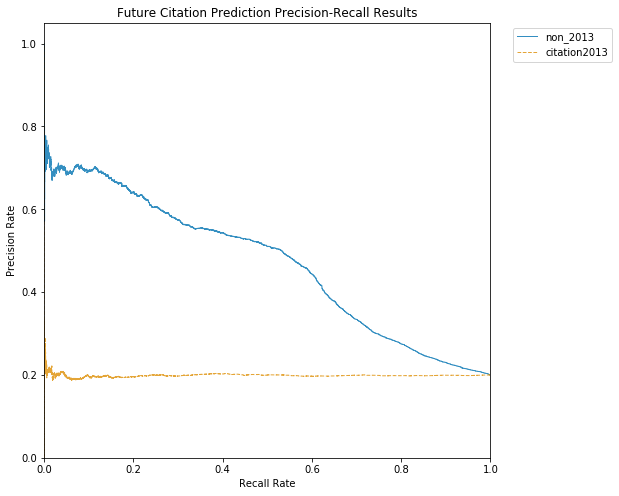

In [31]:
drawPRCMulti(test_yDic,test_probDic)

In [32]:
def drawROCMulti(yDic,probDic):
    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
        probs = probDic[name]
        y     = yDic[name]
        
        if len(set(probs)) > 2:
            fpr, tpr, thresholds = smt.roc_curve(y, probs)
            auc = smt.auc(fpr, tpr)
            ax.step(fpr, tpr, color=palette[i%num_c], alpha=0.8, where='post', label="%s:%.3f"%(name,auc), lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])


    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Future Citation Prediction ROC Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

    fig.savefig("citation_roc_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

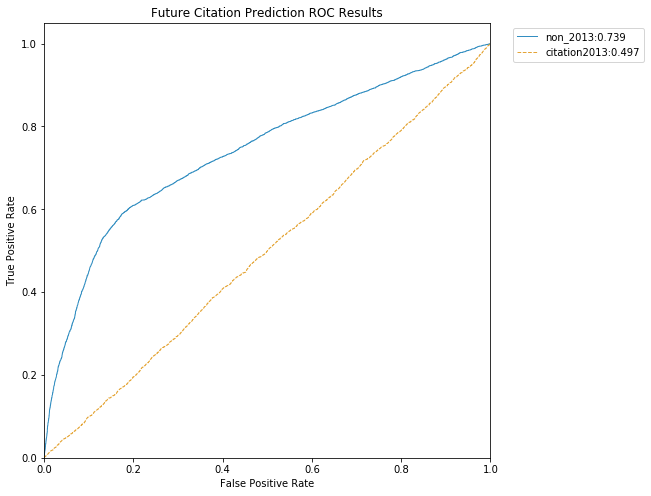

In [33]:
drawROCMulti(test_yDic,test_probDic)